# Sentinel 3 - Level 2 Fire Radiative Power 

https://navigator.eumetsat.int/product/EO:EUM:DAT:0207

https://sentiwiki.copernicus.eu/web/slstr-products#S3-SLSTR-Products-L2-FRP-Products

Here we explore the Sentinel 3 FRP data available for the Landiras and La Teste 2022 wildfires. The plotting an some data formatting is done with helper functions I copied from the EUMETSAT LTPy course (Learning tool for Python on Atmospheric Composition Data) and listed in this notebook: https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/functions.ipynb

## See available files in unzipped archive

In [2]:
import glob

frp_dir = 'S3A_SL_2_FRP____20220718T102425_20220718T102725_20220719T191734_0180_087_336_2160_PS1_O_NT_004.SEN3/'

for f in sorted(glob.glob(frp_dir+'*')):
    print(f.split('/')[-1])

FRP_an.nc
FRP_bn.nc
FRP_in.nc
S3A_SL_2_FRP____20220718T102425_20220718T102725_20220719T191734_0180_087_336_2160_PS1_O_NT_004-ql.jpg
cartesian_fn.nc
cartesian_in.nc
cartesian_tx.nc
flags_fn.nc
flags_in.nc
geodetic_fn.nc
geodetic_in.nc
geodetic_tx.nc
geometry_tn.nc
indices_fn.nc
indices_in.nc
met_tx.nc
time_an.nc
time_bn.nc
time_in.nc
xfdumanifest.xml


In [8]:
import xarray as xr
frp_xr = xr.open_dataset(frp_dir+'FRP_in.nc')
frp_xr

<xarray.Dataset> Size: 7MB
Dimensions:                 (fires: 204, rows: 1200, columns: 1500)
Dimensions without coordinates: fires, rows, columns
Data variables: (12/25)
    BT_MIR                  (fires) float64 2kB ...
    BT_window               (fires) float64 2kB ...
    Day_night               (fires) int8 204B ...
    F1_Fire_pixel_radiance  (fires) float64 2kB ...
    FRP_MWIR                (fires) float64 2kB ...
    FRP_uncertainty_MWIR    (fires) float64 2kB ...
    ...                      ...
    n_cloud                 (fires) int16 408B ...
    n_water                 (fires) int16 408B ...
    n_window                (fires) int16 408B ...
    time                    (fires) datetime64[ns] 2kB ...
    transmittance_MWIR      (fires) float64 2kB ...
    used_channel            (fires) uint8 204B ...
Attributes: (12/17)
    absolute_orbit_number:  33419
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          20220719T191734Z
    history:                  2022-07-19T19:17:34Z: PUGCoreProcessor joborder...
    institution:            PS1
    ...                     ...
    source:                 IPF-SL-2-FRP 01.07
    start_offset:           54808
    start_time:             2022-07-18T10:24:24.821708Z
    stop_time:              2022-07-18T10:27:24.513366Z
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    track_offset:           998

Load latitude and longitude so we can re-grid the data:

In [10]:
lat_frp = frp_xr['latitude']
lon_frp = frp_xr['longitude']

Load FRP compute from MWIR channel:

In [11]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 204)> Size: 2kB
[204 values with dtype=float64]
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

To convert this array to a masked array, we use this helper function: https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/functions.ipynb#generate_masked_array

In [15]:
import numpy as np

def generate_masked_array(xarray, mask, threshold, operator, drop=True):
    """ 
    Applies a mask (e.g. a cloud mask) onto a given xarray.DataArray, based on a given threshold and operator.
    
    Parameters:
        xarray(xarray DataArray): a three-dimensional xarray.DataArray object
        mask(xarray DataArray): 1-dimensional xarray.DataArray, e.g. cloud fraction values
        threshold(float): any number specifying the threshold
        operator(str): operator how to mask the array, e.g. '<', '>' or '!='
        drop(boolean): default is True
        
    Returns:
        Masked xarray.DataArray with NaN values dropped, if kwarg drop equals True
    """
    if(operator=='<'):
        cloud_mask = xr.where(mask < threshold, 1, 0) #Generate cloud mask with value 1 for the pixels we want to keep
    elif(operator=='!='):
        cloud_mask = xr.where(mask != threshold, 1, 0)
    elif(operator=='>'):
        cloud_mask = xr.where(mask > threshold, 1, 0)
    else:
        cloud_mask = xr.where(mask == threshold, 1, 0)
            
    xarray_masked = xr.where(cloud_mask ==1, xarray, np.nan) #Apply mask onto the DataArray
    xarray_masked.attrs = xarray.attrs #Set DataArray attributes 
    if(drop):
        return xarray_masked[~np.isnan(xarray_masked)] #Return masked DataArray
    else:
        return xarray_masked

In [16]:
masked_frp_mwir = generate_masked_array(frp_mwir, frp_mwir, -1.,operator='!=', drop=True)
masked_frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 204)> Size: 2kB
array([   5.15630421,   10.25508147,   85.47469019,    7.60559429,
         23.54510057,   10.62579929,    4.74564912,    4.97304996,
         16.69084927,   39.36445904,   35.01649699,  120.8516917 ,
         38.55759788,   22.84798899,  186.93434243,  112.22803905,
        211.78679534,  247.02045926,   35.13904951,  124.44720939,
         81.7735898 ,   86.29547194,  218.60329434,  100.83350851,
        121.06592015,   98.82993767,   95.83363791,   30.27313531,
        140.84011831,   77.63836911,  223.6885103 ,   93.44269464,
         31.04214673,   58.42737268,  169.28018829,   24.09516607,
         73.08182919,   11.36009085,    5.76120539,   19.81487545,
         20.04369372,   54.81204339,   33.90206508,   63.37774235,
        129.21931966,   22.94587973,  118.74945506,   49.33763006,
         30.62130522,   48.75492562,   46.847413  ,   41.2291391 ,
        133.95895983,  445.38374449,  100.13968104,  281.74947879,
         76.51852886,  941.81717899,   40.18797231,  137.19273166,
         37.63842071,   35.97198568,   75.015509  ,   27.35869529,
         24.59028708,  129.99355945,  173.31376035,   56.60327454,
         98.16185858,  120.31636657,   83.52036581,  154.87990243,
         52.21293126,   41.33038178,   46.54896405,   33.31890785,
         25.33699949,  144.87595061,   26.37364329,  752.40202337,
...
         21.78185289,   45.09191739,   19.92887853,    3.60969077,
          6.86157029,    4.91832054,    8.65131502,    6.85164911,
          4.34894091,    5.02090275,    3.62060474,    3.92071353,
          3.87383978,    3.54256268,    6.98665862,    8.36892559,
          7.97671406,    5.45178393,    4.40615766,   54.89719709,
         15.83513751,   27.17290486,   11.45608922,   13.91509288,
         10.32054412,   12.62702634,   11.30633753,   17.18195609,
         16.04383159,    9.11123063,   12.85368112,   13.63834284,
         15.07342984,   21.85077915,   24.34012782,   80.53766188,
         28.40853795,   36.98324415,   61.8263322 ,   23.19107696,
         32.98188872,   30.96641006,   11.74708561,    7.86350288,
         32.66544626,   18.68670165,   36.28790533,   10.72203894,
         16.46270447,   13.15865626,   13.8528029 ,    8.41999705,
         13.49970753,   16.73772236,   37.60330311,   32.42177049,
         32.55073612,   35.57402856,   29.44930583,   24.88737277,
         25.13795521,   34.1271547 ,   26.29156307,   31.47328849,
         32.84687794,   22.15548769,   27.5380407 ,   78.14383314,
         38.38101198,   32.11714079,   23.52013907,   42.13220652,
         24.55810806,   28.11398294,   33.64055289,   32.68306922,
         28.99101138,   29.00252537,   24.47119891,   29.7618537 ])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

Count fires:

In [21]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(204, 204)

Now we need to grid this data on the lon/lat coordinates we extracted above. Here again we use a helper function from: https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/functions.ipynb

In [18]:
def slstr_frp_gridding(parameter_array, parameter, lat_min, lat_max, lon_min, lon_max, 
                       sampling_lat_FRP_grid, sampling_lon_FRP_grid, n_fire, lat_frp, lon_frp, **kwargs):
    """ 
    Produces gridded data of Sentinel-3 SLSTR NRT Fire Radiative Power Data
    
    Parameters:
        parameter_array(xarray.DataArray): xarray.DataArray with extracted data variable of fire occurences
        parameter(str): NRT S3 FRP channel - either `mwir`, `swir` or `swir_nosaa`
        lat_min, lat_max, lon_min, lon_max(float): Floats of geographical bounding box
        sampling_lat_FRP_grid, sampling_long_FRP_grid(float): Float of grid cell size
        n_fire(int): Number of fire occurences
        lat_frp(xarray.DataArray): Latitude values of occurred fire events
        lon_frp(xarray.DataArray): Longitude values of occurred fire events
        **kwargs: additional keyword arguments to be added. Required for parameter `swir_nosaa`, where the function
                  requires the xarray.DataArray with the SAA FLAG information.  

    Returns:
        the gridded xarray.Data Array and latitude and longitude grid information
    """ 
    n_lat = int( (np.float32(lat_max) - np.float32(lat_min)) / sampling_lat_FRP_grid ) + 1 # Number of rows per latitude sampling
    n_lon = int( (np.float32(lon_max) - np.float32(lon_min)) / sampling_lon_FRP_grid ) + 1 # Number of lines per longitude sampling

    
    slstr_frp_gridded = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.

    lat_grid = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.
    lon_grid = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.
    
    if (n_fire >= 0):
    
    # Loop on i_lat: begins
        for i_lat in range(n_lat):
                    
        # Loop on i_lon: begins
            for i_lon in range(n_lon):
                        
                lat_grid[i_lat, i_lon] = lat_min + np.float32(i_lat) * sampling_lat_FRP_grid + sampling_lat_FRP_grid / 2.
                lon_grid[i_lat, i_lon] = lon_min + np.float32(i_lon) * sampling_lon_FRP_grid + sampling_lon_FRP_grid / 2.
                            
            # Gridded SLSTR FRP MWIR Night - All days
                if(parameter=='swir_nosaa'):
                    FLAG_FRP_SWIR_SAA_nc = kwargs.get('flag', None)
                    mask_grid = np.where( 
                        (lat_frp[:] >= lat_min + np.float32(i_lat) * sampling_lat_FRP_grid)  & 
                        (lat_frp[:] < lat_min + np.float32(i_lat+1) * sampling_lat_FRP_grid) & 
                        (lon_frp[:] >= lon_min + np.float32(i_lon) * sampling_lon_FRP_grid)  & 
                        (lon_frp[:] < lon_min + np.float32(i_lon+1) * sampling_lon_FRP_grid) &
                        (parameter_array[:] != -1.) & (FLAG_FRP_SWIR_SAA_nc[:] == 0), False, True)
                else:
                    mask_grid = np.where( 
                        (lat_frp[:] >= lat_min + np.float32(i_lat) * sampling_lat_FRP_grid)  & 
                        (lat_frp[:] < lat_min + np.float32(i_lat+1) * sampling_lat_FRP_grid) & 
                        (lon_frp[:] >= lon_min + np.float32(i_lon) * sampling_lon_FRP_grid)  & 
                        (lon_frp[:] < lon_min + np.float32(i_lon+1) * sampling_lon_FRP_grid) &
                        (parameter_array[:] != -1.),  False, True)
                            
                masked_slstr_frp_grid = np.ma.array(parameter_array[:], mask=mask_grid)
                            
                if len(masked_slstr_frp_grid.compressed()) != 0:
                    slstr_frp_gridded[i_lat, i_lon]  = np.sum(masked_slstr_frp_grid.compressed())
    return slstr_frp_gridded, lat_grid, lon_grid

In [66]:
sampling_lat_FRP_grid = 0.02        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.02        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 500.         # Max Integrated FRP value, for plots


lat_min               = 44.14        # Minimum latitude for mapping plot [deg N]
lat_max               = 44.89       # Maximum latitude for mapping plot [deg N]
lon_min               = -1.55        # Minimum lonitude for mapping plot [deg E]
lon_max               = -0.25        # Maximum lonitude for mapping plot [deg E]

In [67]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array = frp_mwir, 
                                                       parameter = 'mwir', 
                                                       lat_min = lat_min, 
                                                       lat_max = lat_max, 
                                                       lon_min = lon_min, 
                                                       lon_max = lon_max, 
                                                       sampling_lat_FRP_grid = sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid = sampling_lon_FRP_grid,
                                                       lat_frp = lat_frp,
                                                       lon_frp = lon_frp,
                                                       n_fire = n_fire_MWIR)

In [68]:
# Mask out invalid pixels:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir          = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)

# Calculate some statistics and add them to a string that can be integrated in the final plot. 
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)


FRP_sum      = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'


In [69]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def visualize_s3_frp(data, lat, lon, unit, longname, textstr_1, textstr_2, vmax):
    """ 
    Visualizes a numpy.Array (Sentinel-3 SLSTR NRT FRP data) with matplotlib's pcolormesh function and adds two
    text boxes to the plot.
    
    Parameters:
        data(numpy.MaskedArray): any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        lat(numpy.Array): array with longitude values
        lon(numpy.Array) : array with latitude values
        unit(str): unit of the resulting plot
        longname(str): Longname to be used as title
        textstr_1(str): String to fill box 1
        textstr_2(str): String to fill box 2
        vmax(float): Maximum value of color scale
    """
    fig=plt.figure(figsize=(20, 15))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.pcolormesh(lon, lat, data, 
                        cmap=cm.autumn_r, transform=ccrs.PlateCarree(),
                        vmin=0,
                        vmax=vmax)

    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.bottom_labels=False
    gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.029, pad=0.025)
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(longname, fontsize=20, pad=40.0) 

    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box on the right side of the plot
    ax.text(1.1, 0.9, textstr_1, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(1.1, 0.85, textstr_2, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    plt.show()

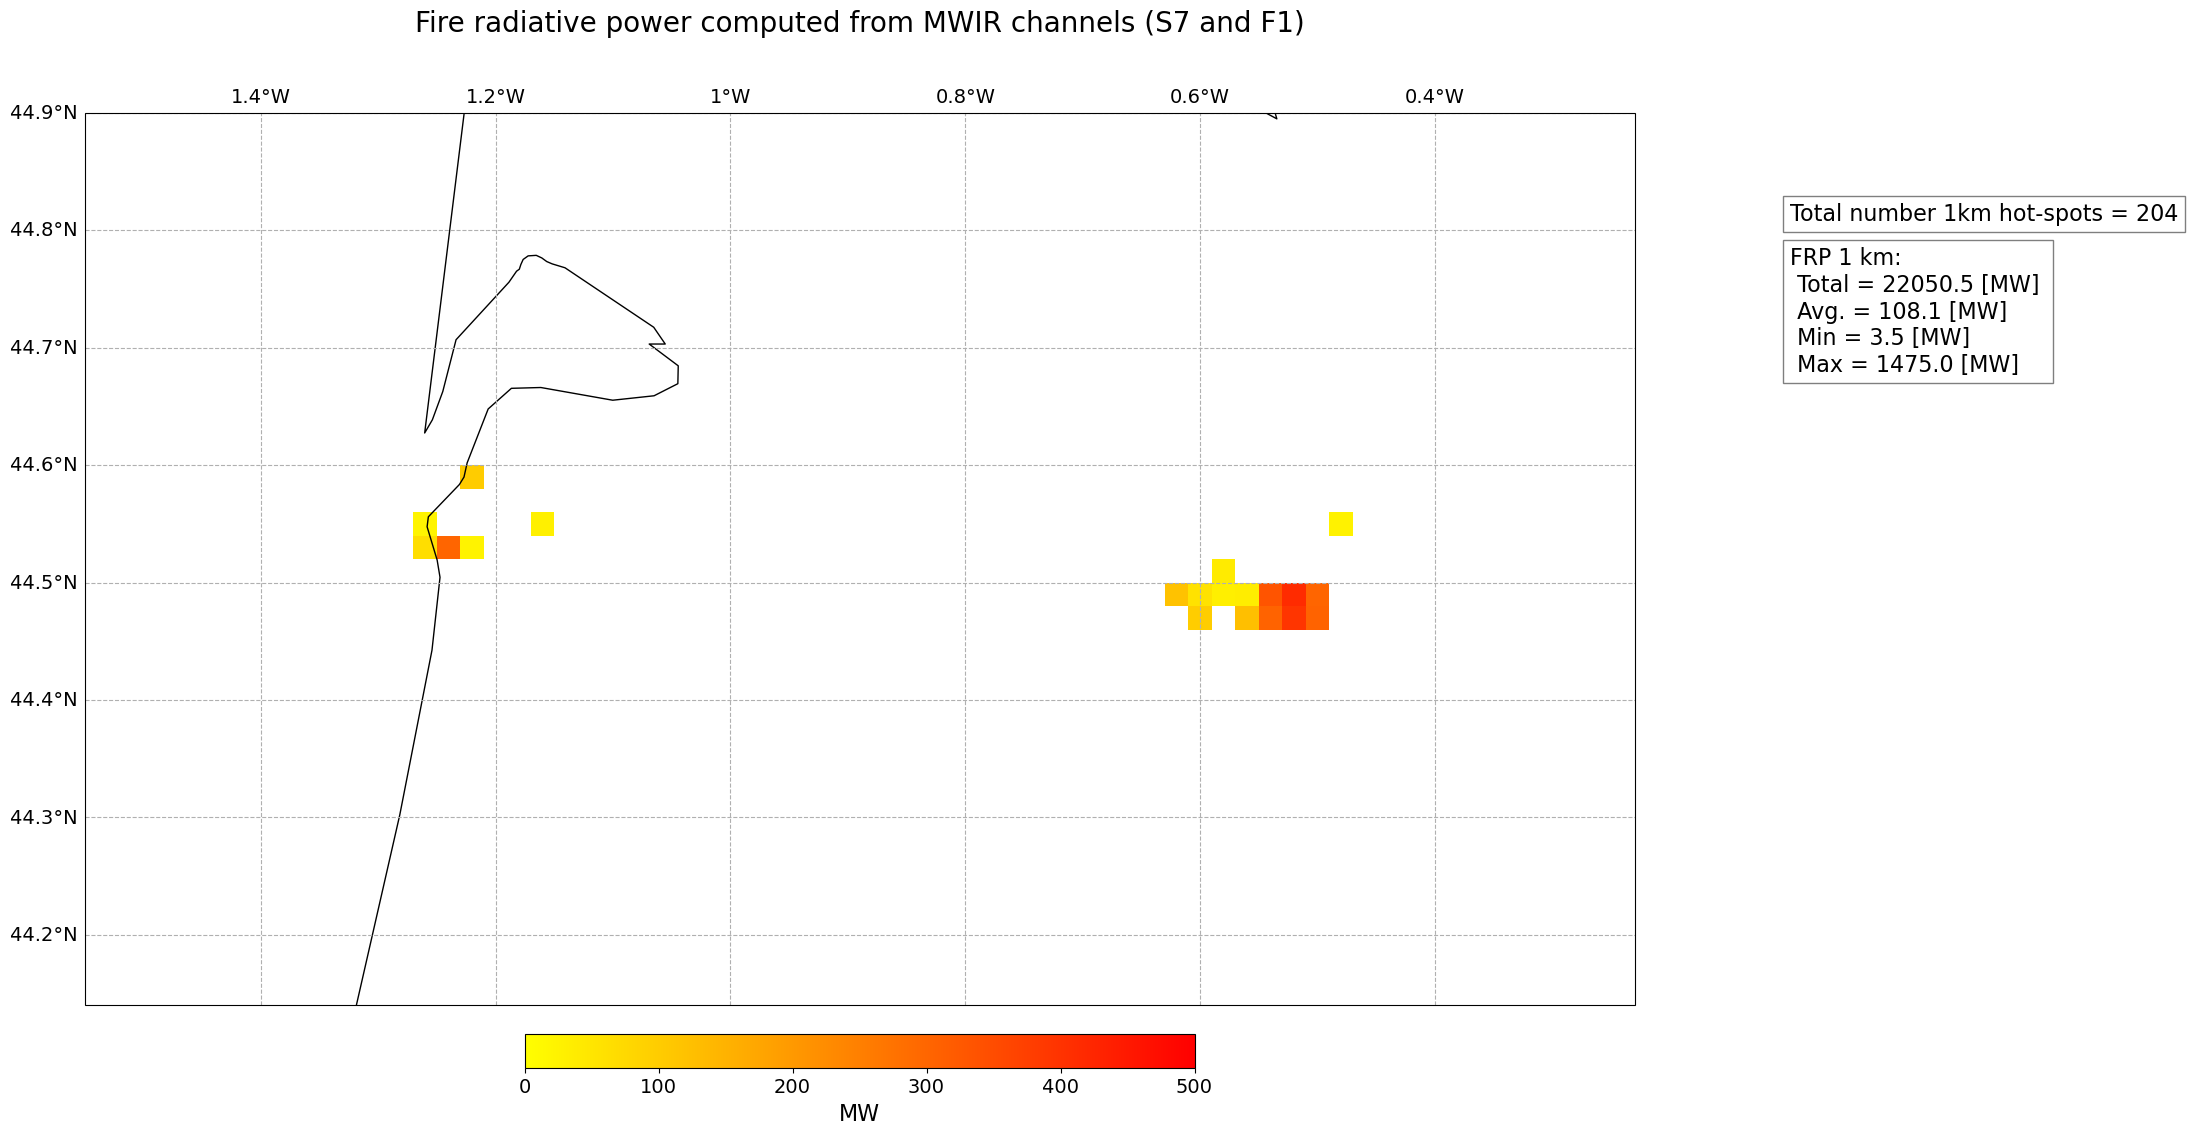

In [70]:
long_name = frp_mwir.long_name
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data = D_mwir[:,:],
                 lat = lat_grid, 
                 lon = lon_grid, 
                 unit = unit, 
                 longname = long_name, 
                 textstr_1 = textstr_1, 
                 textstr_2 = textstr_2, 
                 vmax = FRP_plot_max_grid)